In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
np.random.seed(1)

In [2]:
data = []
labelsIncluded = [1,2,3,4]
path = './UCI_HAR_Dataset/test/Inertial_Signals/'
xaccel = pd.read_csv(path + 'total_acc_x_test.txt', sep=" ",  header=None, skipinitialspace= True, skip_blank_lines= False).to_numpy()
yaccel = pd.read_csv(path + 'total_acc_y_test.txt', sep=" ",  header=None, skipinitialspace= True, skip_blank_lines= False).to_numpy()
zaccel = pd.read_csv(path + 'total_acc_z_test.txt', sep=" ",  header=None, skipinitialspace= True, skip_blank_lines= False).to_numpy()
labels = pd.read_csv('./UCI_HAR_Dataset/test/y_test.txt', sep=" ",  header=None, skipinitialspace= True, skip_blank_lines= False).to_numpy()
mask = np.isin(labels.flatten(), labelsIncluded)

xaccel= xaccel[mask,:]
yaccel= yaccel[mask,:]
zaccel= zaccel[mask,:]
labels = labels[mask,:].flatten()

totalAccel = np.dstack((xaccel,yaccel,zaccel))
X_train, X_test, y_train, y_test = train_test_split(totalAccel, labels, test_size=0.5)
print(X_train.shape, y_train.shape)


(939, 128, 3) (939,)


In [3]:
Xtrain1 = X_train[y_train == 1,:,:]
Xtrain2 = X_train[y_train == 2,:,:]
Xtrain3 = X_train[y_train == 3,:,:]
Xtrain4 = X_train[y_train == 4,:,:]
Xtrain1 = np.vstack(Xtrain1)
Xtrain2 = np.vstack(Xtrain2)
Xtrain3 = np.vstack(Xtrain3)
Xtrain4 = np.vstack(Xtrain4)
print(Xtrain1.shape,Xtrain2.shape, Xtrain3.shape,Xtrain4.shape)

(33792, 3) (29824, 3) (26624, 3) (29952, 3)


### VAR training

In [4]:
#Plan: Use Matrix compact form and do Psuedo inverse (https://handwiki.org/wiki/General_matrix_notation_of_a_VAR(p))

def getVARWeights(dataMat, N=4): #dataMat.shape = (timestamps, Dimensions). Returns a Weights mat where first column is bias and then the rest is NXN chunks. look at link.
    Y = np.zeros((dataMat.shape[1], dataMat.shape[0]-N))
    Z = np.zeros((1+ N *dataMat.shape[1] ,dataMat.shape[0]-N))
    Z[0,:] = 1
    for i in range(N,dataMat.shape[0]):
        Y[:,i-N] = dataMat[i]
    for i in range(0,N):
        for j in range(0,dataMat.shape[0]-N):
            rowIdx = 1 + i*3 
            Z[rowIdx:rowIdx + dataMat.shape[1],j] = dataMat[N-1-i+j,:]
    toReturn = Y @ np.linalg.pinv(Z)
    return toReturn
def predictSamples(dataMat, WeightMat, N = 4): # returns the samples that we can predict. Assumes Data is shape (timestamps, Dimensions) and returns shape (timestamps - Norder, Dimensions) since cant predict first Norder samples.
    Z = np.zeros((1+ N *dataMat.shape[1] ,dataMat.shape[0]-N))
    Z[0,:] = 1
    for i in range(0,N):
        for j in range(0,dataMat.shape[0]-N):
            rowIdx = 1 + i*3 
            Z[rowIdx:rowIdx + dataMat.shape[1],j] = dataMat[N-1-i+j,:]
    return (WeightMat @ Z).T

def predictLabel(dataMat, allWeights, N = 4): #Assumes Data is shape (timestamps, Dimensions) and returns label based on order allWeights passed in and which prediction has least squared error
    groundTruth = dataMat[N:,:]
    errors = np.zeros(len(allWeights))
    for i in range(len(allWeights)):
        predicted = predictSamples(dataMat,allWeights[i],N)
        # errors[i] = np.multiply(predicted,groundTruth)
        errors[i] = np.sum(np.square(groundTruth - predictSamples(dataMat,allWeights[i],N)))
    return np.argmin(errors)

Norder = 15
WeightMatAct1 = getVARWeights(Xtrain1, N=Norder)
WeightMatAct2 = getVARWeights(Xtrain2,N=Norder)
WeightMatAct3 = getVARWeights(Xtrain3,N = Norder)
WeightMatAct4 = getVARWeights(Xtrain4, N = Norder)

allWeights = [WeightMatAct1,WeightMatAct2,WeightMatAct3,WeightMatAct4]

In [5]:
# print(y_train[1])
# GTvisual = X_train[0,Norder:,2]
# prediction = predictSamples(X_train[0],WeightMatAct3,Norder)[:,2]
# plt.plot(GTvisual)
# plt.plot(prediction)

In [6]:
trainConfMat = np.zeros((4,4))
testConfMat = np.zeros((4,4))

for i in range(X_train.shape[0]):
    yhat = predictLabel(X_train[i], allWeights, N=Norder)
    y = y_train[i]
    trainConfMat[yhat,y-1] +=1

for i in range(X_test.shape[0]):
    yhat = predictLabel(X_test[i], allWeights, N=Norder)
    y = y_test[i]
    testConfMat[yhat,y-1] +=1

Using 15 past samples to predict


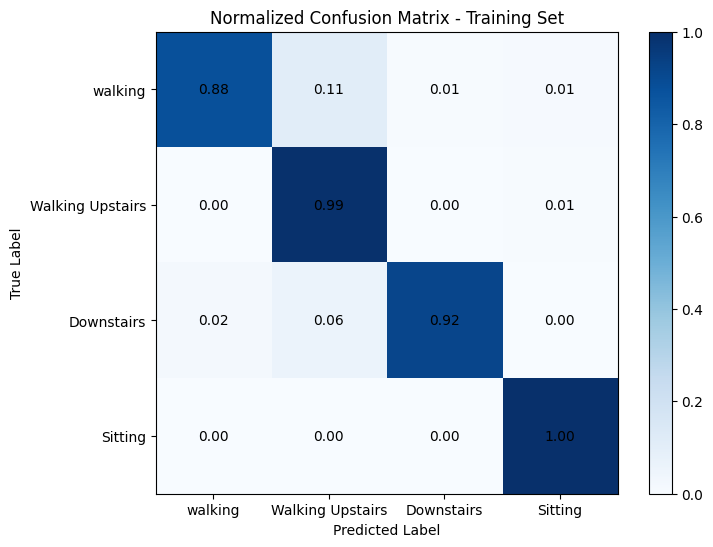

In [7]:
trainConfMatNormalized = trainConfMat.astype('float') / trainConfMat.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))
cax = plt.imshow(trainConfMatNormalized, cmap="Blues")
for i in range(trainConfMatNormalized.shape[0]):
    for j in range(trainConfMatNormalized.shape[1]):
        plt.text(j, i, f'{trainConfMatNormalized[i, j]:.2f}', ha='center', va='center', color='black')

plt.xticks(np.arange(trainConfMatNormalized.shape[1]), ["walking", "Walking Upstairs", "Downstairs", "Sitting"])
plt.yticks(np.arange(trainConfMatNormalized.shape[0]), ["walking", "Walking Upstairs", "Downstairs", "Sitting"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix - Training Set')

cbar = plt.colorbar(cax)
print("Using", Norder, "past samples to predict")

plt.show()

Using 15 past samples to predict


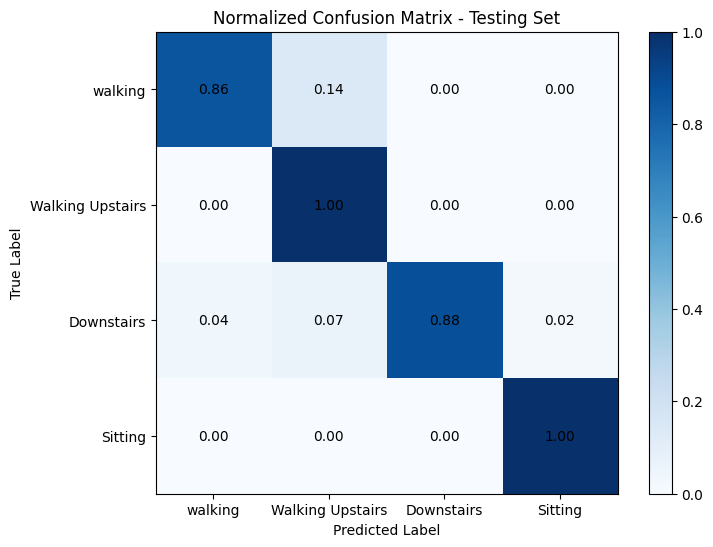

In [8]:
testConfMatNormalized = testConfMat.astype('float') / testConfMat.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))
cax = plt.imshow(testConfMatNormalized, cmap="Blues")
for i in range(testConfMatNormalized.shape[0]):
    for j in range(testConfMatNormalized.shape[1]):
        plt.text(j, i, f'{testConfMatNormalized[i, j]:.2f}', ha='center', va='center', color='black')

plt.xticks(np.arange(testConfMatNormalized.shape[1]), ["walking", "Walking Upstairs", "Downstairs", "Sitting"])
plt.yticks(np.arange(testConfMatNormalized.shape[0]), ["walking", "Walking Upstairs", "Downstairs", "Sitting"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix - Testing Set')

print("Using", Norder, "past samples to predict")

cbar = plt.colorbar(cax)

plt.show()